In [47]:
# This cell contains all function definitions
from csv import reader
from random import randrange
from math import sqrt
from random import random
from math import exp
import numpy as np
import fpdf
import matplotlib.pyplot as plt

def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file); next(csv_reader)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())
        
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split dataset into training set and test set
def split_data(dataset, train_percentage):
    train_set = list()
    test_set = list()
    dataset_copy = list(dataset)
    train_size = int((train_percentage/100) * len(dataset))
    while len(train_set) < train_size:
        index = randrange(len(dataset_copy))
        train_set.append(dataset_copy.pop(index))
    test_set = dataset_copy
    return train_set,test_set

# calculate column means
def column_means(dataset):
	means = [0 for i in range(len(dataset[0])-1)]
	for i in range(len(dataset[0])-1):
		col_values = [row[i] for row in dataset]
		means[i] = sum(col_values) / float(len(dataset))
	return means

# calculate column standard deviations
def column_stdevs(dataset, means):
	stdevs = [0 for i in range(len(dataset[0])-1)]
	for i in range(len(dataset[0])-1):
		variance = [pow(row[i]-means[i], 2) for row in dataset]
		stdevs[i] = sum(variance)
	stdevs = [sqrt(x/(float(len(dataset)))) for x in stdevs]
	return stdevs

# standardize dataset
def standardize_dataset(dataset, means, stdevs):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - means[i]) / stdevs[i]
            
# append a 1 for each feature vector (corresponding to the bias)
def append_1(dataset):
    for row in dataset:
        row.insert(-1,1)
            
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    error = []
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)] # one hot encoding
            expected[row[-1]] = 1
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        error.append(sum_error)
    return error
            
# Forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row[:-1]
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs; 
        if layer!=network[-1]: inputs.append(1)
    return inputs

# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]*inputs[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

# Transfer neuron activation
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(neuron['output'] - expected[j])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)

# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]; inputs.append(1)
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
                
# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs)),outputs

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Calculate root mean squared error between predictions and actual values
def rms_metric(actual_one_hot,predictions_one_hot):
    rms_error = 0
    for i in range(actual_one_hot.shape[0]):
        ms_error = sum((actual_one_hot[i,j]-predictions_one_hot[i,j])**2 for j in range(actual_one_hot.shape[1]))
        rms_error += np.sqrt(ms_error)
 
    return rms_error 

In [44]:
# Main code begins here
# load data
filename = 'winequality_red.csv'
dataset = load_csv(filename)

# prepare data
# convert string column to float
for i in range(len(dataset[0])-1):
    str_column_to_float(dataset, i)
    
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

# split data
train_set,test_set = split_data(dataset,50)

# standardize data
# calculate the mean and standard deviation of each column using training set
means = column_means(train_set)
stdevs = column_stdevs(train_set, means)
#print(means)
#print(stdevs)
standardize_dataset(dataset, means, stdevs)

# append a 1 to each feature vector (corresponding to the bias term)
append_1(dataset)

# set the number of hidden units, number of iterations to run (epochs), and learning rate
l_rate = [0.08,0.1,0.3] # three different learning weights
n_epoch = 1000
n_hidden = 30

# set the number of inputs and outputs
n_inputs = len(train_set[0]) - 1
n_outputs = len(set([row[-1] for row in train_set]))

# Backpropagation algorithm with stochastic gradient descent (for three different learning rates)
errors = list()
for i in range(len(l_rate)):
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    error = train_network(network, train_set, l_rate[i], n_epoch, n_outputs) #train_network() calls forward and backward
    errors.append(error)


In [63]:
# make predictions on test set
predictions = list()
predictions_one_hot = list()
for row in test_set:
    prediction,prediction_one_hot = predict(network, row) # predict() calls the forward function
    predictions.append(prediction)
    predictions_one_hot.append(prediction_one_hot)

predictions_one_hot = np.array(predictions_one_hot)

# one hot encode actual/ground truth values
actual_one_hot = list()
for row in test_set:
    act_one_hot = [0 for i in range(n_outputs)] # one hot encoding
    act_one_hot[row[-1]] = 1
    actual_one_hot.append(act_one_hot)

actual_one_hot = np.array(actual_one_hot)

# calculate root mean squared error between predictions and actual values
rms_error = rms_metric(actual_one_hot,predictions_one_hot)
print(rms_error)

# calculate accuracy (percentage of predictions that match the true labels)
actual = [row[-1] for row in test_set]
accuracy = accuracy_metric(actual, predictions)
print(accuracy)

# print rms error and accuracy in a pdf file
pdf = fpdf.FPDF(format='letter')
pdf.add_page()
pdf.set_font("Arial", size=12)
pdf.write(5,"RMS error = {}\n".format(rms_error))
pdf.write(5,"Accuracy = {}%".format(accuracy))
pdf.output("report.pdf")


477.4099071679535
61.375


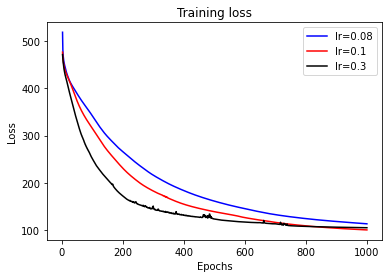

In [64]:
# plot the error
epochs = range(1,n_epoch+1)
plt.plot(epochs[2:],errors[0][2:],'b',label='lr={}'.format(l_rate[0]))
plt.plot(epochs[2:],errors[1][2:],'r',label='lr={}'.format(l_rate[1]))
plt.plot(epochs[2:],errors[2][2:],'k',label='lr={}'.format(l_rate[2]))
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
